#Dataset Overview
We will be using the two publicly available dataset for this case study. <br>
1. Smartphone Image Denoising Dataset (SIDD):- <br>
It consists of 320 image pairs of clean and its corresponding noisy image.

2. RENOIR Dataset :- A Dataset for Real Low-Light Image Noise Reduction.<br>
We will take 221 clean-noisy image pairs from this dataset

In [1]:
!wget --header="Host: doc-0k-bg-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_go379gq09f5kfp5garfun8onviql2tj3_nonce=tkhv8rbk717b6; _ga=GA1.2.529575585.1594656665" --header="Connection: keep-alive" "https://doc-0k-bg-docs.googleusercontent.com/docs/securesc/jlk24o4mos1tou6a1qcjiuk7lhjafog8/it1nthv19o2ncb0o2gkbm9dcdda7k6qb/1627724175000/10434157120280891651/10434157120280891651/10kIu2PTCsJlNWi68RWN0Lqiid7xqQmoo?e=download&authuser=2&nonce=tkhv8rbk717b6&user=10434157120280891651&hash=k9heuoaso5bf3qqjr869f7h65pc460ft" -c -O 'renoir.zip'

--2023-11-30 16:45:53--  https://doc-0k-bg-docs.googleusercontent.com/docs/securesc/jlk24o4mos1tou6a1qcjiuk7lhjafog8/it1nthv19o2ncb0o2gkbm9dcdda7k6qb/1627724175000/10434157120280891651/10434157120280891651/10kIu2PTCsJlNWi68RWN0Lqiid7xqQmoo?e=download&authuser=2&nonce=tkhv8rbk717b6&user=10434157120280891651&hash=k9heuoaso5bf3qqjr869f7h65pc460ft
Resolving doc-0k-bg-docs.googleusercontent.com (doc-0k-bg-docs.googleusercontent.com)... 142.250.148.132, 2607:f8b0:4001:c54::84
Connecting to doc-0k-bg-docs.googleusercontent.com (doc-0k-bg-docs.googleusercontent.com)|142.250.148.132|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-11-30 16:45:53 ERROR 403: Forbidden.



In [2]:
!unzip renoir.zip

Archive:  renoir.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of renoir.zip or
        renoir.zip.zip, and cannot find renoir.zip.ZIP, period.


In [ ]:
!unzip combined.zip

In [ ]:
!pip install patchify

In [ ]:
#Importing relevant libraries
import os
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import seaborn as sns
import random
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Flatten, Dense, Input, MaxPooling2D, Add, Reshape, concatenate, AveragePooling2D, Multiply, GlobalAveragePooling2D, UpSampling2D, MaxPool2D,Softmax
from tensorflow.keras.activations import softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
%load_ext tensorboard

##Extracting Image paths for SIDD Dataset

In [ ]:
dir = os.listdir('/content/SIDD_Medium_Srgb/Data')
folders=[]
for folder in dir:
  folders.append(folder)

GT = []
Noisy = []
for folder in folders:
  files = os.listdir('/content/SIDD_Medium_Srgb/Data/'+folder)
  for img in files:
    if img[5]=='G':
      GT.append('/content/SIDD_Medium_Srgb/Data/'+folder+'/'+img)
    else:
      Noisy.append('/content/SIDD_Medium_Srgb/Data/'+folder+'/'+img)

In [ ]:
df_SIDD = pd.DataFrame()
df_SIDD['Ground Truth Images'] = GT
df_SIDD['Noisy Images'] = Noisy
df_SIDD.head()

,Ground Truth Images,Noisy Images
0,/content/SIDD_Medium_Srgb/Data/0030_001_IP_016...,/content/SIDD_Medium_Srgb/Data/0030_001_IP_016...
1,/content/SIDD_Medium_Srgb/Data/0030_001_IP_016...,/content/SIDD_Medium_Srgb/Data/0030_001_IP_016...
2,/content/SIDD_Medium_Srgb/Data/0194_009_IP_016...,/content/SIDD_Medium_Srgb/Data/0194_009_IP_016...
3,/content/SIDD_Medium_Srgb/Data/0194_009_IP_016...,/content/SIDD_Medium_Srgb/Data/0194_009_IP_016...
4,/content/SIDD_Medium_Srgb/Data/0004_001_S6_001...,/content/SIDD_Medium_Srgb/Data/0004_001_S6_001...


In [ ]:
df_SIDD.shape

(320, 2)

##Extracting Image paths for RENOIR Dataset

In [ ]:
df_renoir = pd.DataFrame()
dir = os.listdir('/content/GroundTruth')
GT = []
Nsy=[]
for image in dir:
  GT.append('/content/GroundTruth/'+image)

dir = os.listdir('/content/Noisy')
for image in dir:
  Nsy.append('/content/Noisy/'+image)

df_renoir['Ground Truth Images'] = GT
df_renoir['Noisy Images'] = Nsy
df_renoir.head()

,Ground Truth Images,Noisy Images
0,/content/GroundTruth/206.bmp,/content/Noisy/206.bmp
1,/content/GroundTruth/207.bmp,/content/Noisy/207.bmp
2,/content/GroundTruth/201.bmp,/content/Noisy/201.bmp
3,/content/GroundTruth/183.bmp,/content/Noisy/183.bmp
4,/content/GroundTruth/11.bmp,/content/Noisy/11.bmp


In [ ]:
df_renoir.shape

(221, 2)

##Combining SIDD and RENOIR Dataset

In [ ]:
#Merging the two datasets (SIDD and RENOIR)
df = pd.concat([df_SIDD,df_renoir],ignore_index=True)
df = df.sample(frac = 1)
df = df.reset_index(drop=True)
df

,Ground Truth Images,Noisy Images
0,/content/SIDD_Medium_Srgb/Data/0062_003_S6_032...,/content/SIDD_Medium_Srgb/Data/0062_003_S6_032...
1,/content/GroundTruth/112.bmp,/content/Noisy/112.bmp
2,/content/SIDD_Medium_Srgb/Data/0196_009_IP_008...,/content/SIDD_Medium_Srgb/Data/0196_009_IP_008...
3,/content/GroundTruth/25.bmp,/content/Noisy/25.bmp
4,/content/GroundTruth/189.bmp,/content/Noisy/189.bmp
...,...,...
536,/content/GroundTruth/78.bmp,/content/Noisy/78.bmp
537,/content/SIDD_Medium_Srgb/Data/0098_005_G4_001...,/content/SIDD_Medium_Srgb/Data/0098_005_G4_001...
538,/content/GroundTruth/46.bmp,/content/Noisy/46.bmp
539,/content/SIDD_Medium_Srgb/Data/0033_001_IP_001...,/content/SIDD_Medium_Srgb/Data/0033_001_IP_001...


#Exploratory Data Analysis

##Image Sizes

In [ ]:
size=[]
for i in range(len(df)):
  img_gt = cv2.imread(df['Ground Truth Images'].iloc[i])
  size.append(img_gt.shape)

In [ ]:
df['image size'] = size
df['image size'] = df['image size'].astype(str)
df.head()

,Ground Truth Images,Noisy Images,image size
0,/content/GroundTruth/95.bmp,/content/Noisy/95.bmp,"(2760, 3684, 3)"
1,/content/SIDD_Medium_Srgb/Data/0137_006_IP_016...,/content/SIDD_Medium_Srgb/Data/0137_006_IP_016...,"(3024, 4032, 3)"
2,/content/SIDD_Medium_Srgb/Data/0189_008_IP_004...,/content/SIDD_Medium_Srgb/Data/0189_008_IP_004...,"(3024, 4032, 3)"
3,/content/SIDD_Medium_Srgb/Data/0004_001_S6_001...,/content/SIDD_Medium_Srgb/Data/0004_001_S6_001...,"(3000, 5328, 3)"
4,/content/GroundTruth/139.bmp,/content/Noisy/139.bmp,"(2760, 3684, 3)"


Text(0, 0.5, 'No. of images')

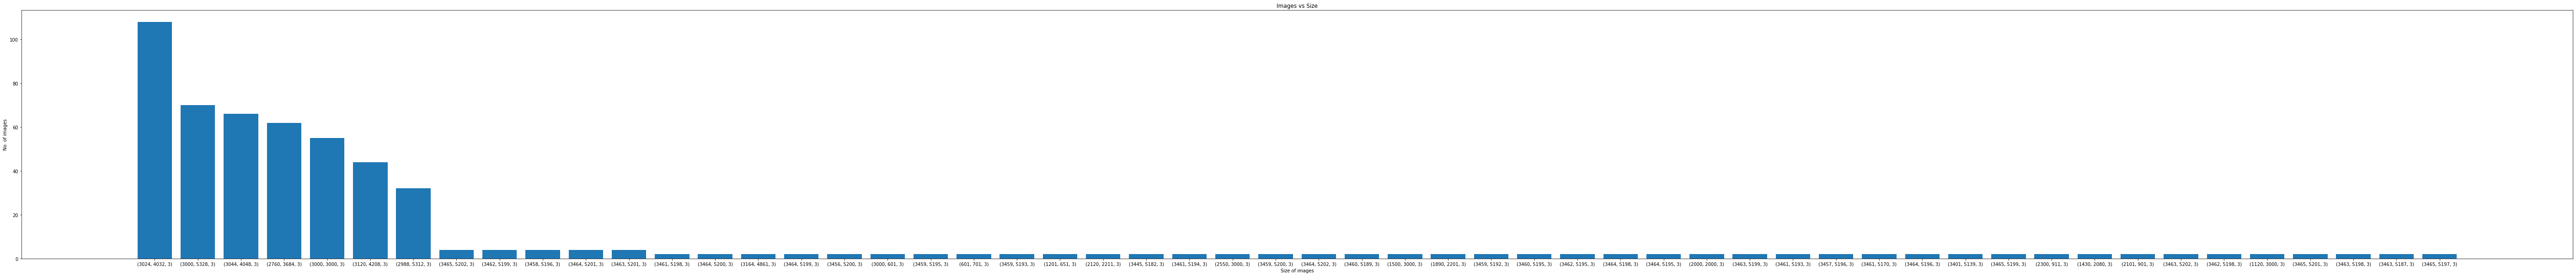

In [ ]:
fig = plt.figure(figsize = (100, 10))
y = list(df['image size'].value_counts())
x = df['image size'].value_counts().index.tolist()
plt.bar(x,y)
plt.title("Images vs Size")
plt.xlabel("Size of images")
plt.ylabel("No. of images")

Observation : Most number of images have size (3024 x 4032).

##Splitting the dataset into train and test datasets

In [ ]:
X = df['Noisy Images']
y = df['Ground Truth Images']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
#Storing the image patches as pickle files
import pickle
pickle.dump((X_train,y_train),open('train_path.pkl','wb'))
pickle.dump((X_test,y_test),open('test_path.pkl','wb'))

In [ ]:
X_train, y_train = pickle.load(open('train_path.pkl', 'rb'))
X_test,y_test = pickle.load(open('test_path.pkl', 'rb'))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(432,)
(432,)
(109,)
(109,)


##Creating Patches

In [ ]:
def patches(img,patch_size):
  patches = patchify(img, (patch_size, patch_size, 3), step=patch_size)
  return patches

In [ ]:
sample = pd.DataFrame({'Ground Truth Images':['a','/content/0062_GT_SRGB_010.PNG'], 'Noisy Images':['b','/content/0062_NOISY_SRGB_010.PNG']})
sample

,Ground Truth Images,Noisy Images
0,a,b
1,/content/0062_GT_SRGB_010.PNG,/content/0062_NOISY_SRGB_010.PNG


In [ ]:
#Creating patches for a Ground Truth Image
path = sample['Ground Truth Images'].iloc[1]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: {}'.format(img.shape))

patches_gt = patches(img,256)
print('Patch shape: {}'.format(patches_gt.shape))

Image shape: (3000, 5328, 3)
Patch shape: (11, 20, 1, 256, 256, 3)


In [ ]:
#Creating patches for a Noisy Image
path = sample['Noisy Images'].iloc[1]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: {}'.format(img.shape))

patches_nsy = patches(img,256)
print('Patch shape: {}'.format(patches_nsy.shape))

Image shape: (3000, 5328, 3)
Patch shape: (11, 20, 1, 256, 256, 3)


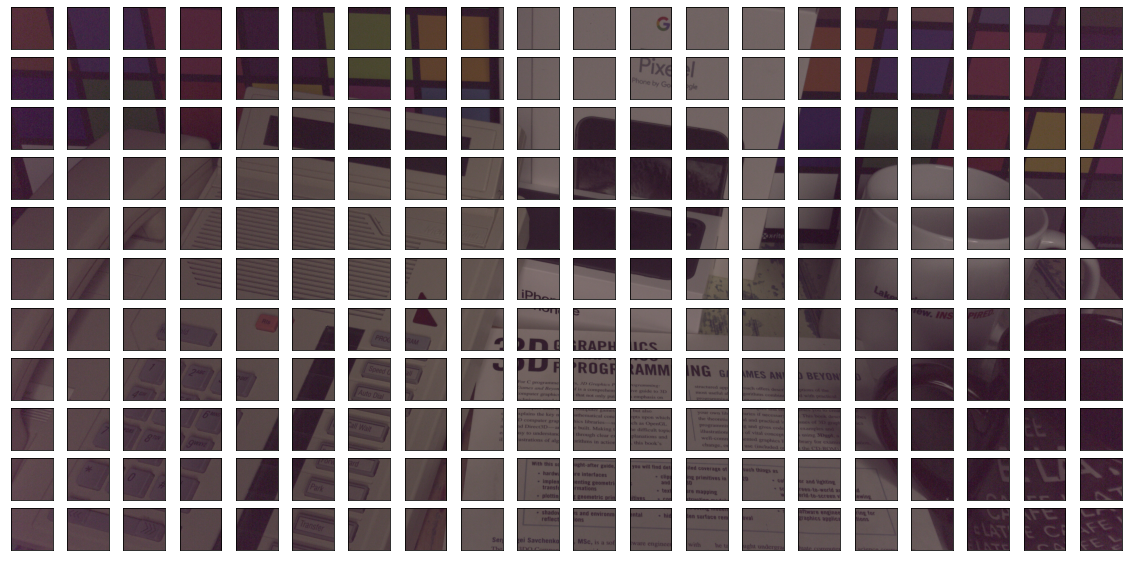

In [ ]:
rows = patches_nsy.shape[0]
cols = patches_nsy.shape[1]
fig, axs = plt.subplots(rows,cols,figsize=(20,10))
for i in range(rows):
  for j in range(cols):
    axs[i][j].imshow(patches_gt[i][j][0])
    axs[i][j].get_xaxis().set_visible(False)
    axs[i][j].get_yaxis().set_visible(False)

This is what patches does. It splits the images into different patches based on a given patch size.

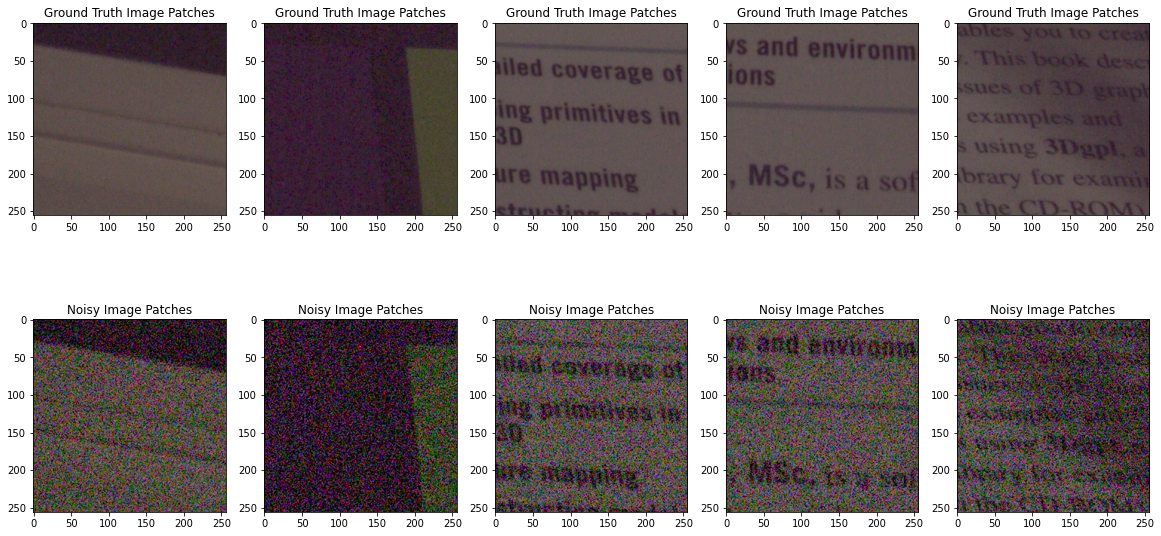

In [ ]:
fig, axs = plt.subplots(1,5,figsize=(20,10))
r = random.sample(range(0, rows), 5)
c = random.sample(range(0, cols), 5)
fig.suptitle('Train Image Patches',fontweight ="bold")
for i in range(5):
  axs[i].imshow(patches_gt[r[i]][c[i]][0])
  axs[i].set_title('Ground Truth Image Patches')
  axs[i].imshow(patches_nsy[r[i]][c[i]][0])
  axs[i].set_title('Noisy Image Patches')


We can clearly see the difference between ground truth image patches and noisy image patches. There is significant amount on noisy in the noisy image patches and this is what we are trying to remove. <br>

We will be creating patches for all the images. Experiments have shown that splitting images into patches and using these patches for training improve model performance in denoising. In regard to that, we will resize all the images to a fixed size of 1024 x 1024 and create patches with patch size 256 x 256.

In [ ]:
#Creating patches for X_train and y_train
X_train_patches = []
y_train_patches = []
for i in range(len(X_train)):
  path = X_train.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_train images
  patches_nsy = patches(img_nsy,256)

  path = y_train.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_train images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_train_patches.append(patches_nsy[j][k][0])
      y_train_patches.append(patches_gt[j][k][0])

X_train = np.array(X_train_patches)
y_train = np.array(y_train_patches)

In [ ]:
#Creating patches for X_test and y_test
X_test_patches = []
y_test_patches = []
for i in range(len(X_test)):
  path = X_test.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_test images
  patches_nsy = patches(img_nsy,256)

  path = y_test.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_test images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_test_patches.append(patches_nsy[j][k][0])
      y_test_patches.append(patches_gt[j][k][0])

X_test = np.array(X_test_patches)
y_test = np.array(y_test_patches)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6912, 256, 256, 3)
(6912, 256, 256, 3)
(1744, 256, 256, 3)
(1744, 256, 256, 3)


In [ ]:
print("Total number of image patches on train data : ", len(X_train))
print("Total number of image patches on test data : ", len(X_test))

Total number of image patches on train data :  6912
Total number of image patches on test data :  1744


After creating image patches, there are a total of 6912 image patches in train dataset and 1744 image patches in test dataset.

In [ ]:
#Storing the image patches as pickle files
import pickle
pickle.dump((X_train,y_train),open('train_data.pkl','wb'))
pickle.dump((X_test,y_test),open('test_data.pkl','wb'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r '/content/train_data.pkl' '/content/drive/MyDrive/Image_denoising_CS2'

In [ ]:
!cp -r '/content/test_data.pkl' '/content/drive/MyDrive/Image_denoising_CS2'

Observation : The noisy images seems to have smoother pixel intensity distribution compared to clean images. Also many pixels in noisy images takes zero pixel value compared to the corresponding pixel values of its clean image.

##Analyzing the PSNR and SSIM values of the images

In [ ]:
from tqdm import tqdm
SSIM = [];PSNR = [];
for i in tqdm(range(len(df))):
  path = df['Ground Truth Images'].iloc[i]
  img1 = cv2.imread(path)
  img1 = img1.astype("float32") / 255.0
  path = df['Noisy Images'].iloc[i]
  img2 = cv2.imread(path)
  img2 = img2.astype("float32") / 255.0
  SSIM.append(ssim(img1,img2,multichannel=True,data_range=img2.max() - img2.min()))
  PSNR.append(psnr(img1,img2))

100%|██████████| 541/541 [1:41:54<00:00, 11.30s/it]


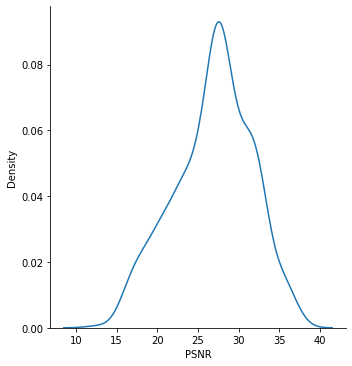

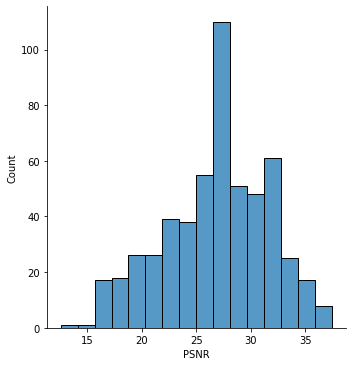

In [ ]:
ax = sns.displot(PSNR,kind='kde')
ax.set(xlabel='PSNR', ylabel='Density')
ax = sns.displot(PSNR)
ax.set(xlabel='PSNR', ylabel='Count')

Observations : Majority of the clean-noisy image pairs have PSNR value between 25-30. So, a good denoising model should give PSNR value greater than 30 (approx) for majority of the images.

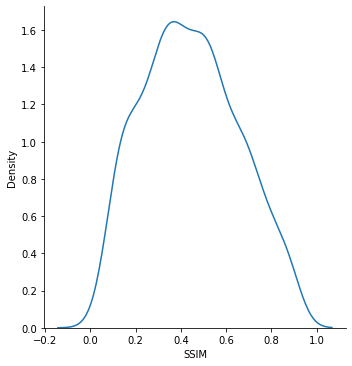

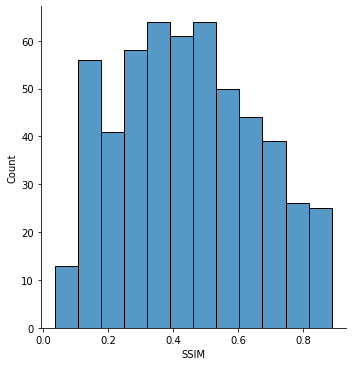

In [ ]:
ax = sns.displot(SSIM,kind='kde')
ax.set(xlabel='SSIM', ylabel='Density')
ax = sns.displot(SSIM)
ax.set(xlabel='SSIM', ylabel='Count')

#Creating Dataset for modeling using custom data generators in Keras

In [ ]:
!wget --header="Host: doc-0s-5o-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_6nk0i0gorcoc4om1b7842ci57p2gpt91=18173784761795238995|1627016175000|ok93qrc94ql5e5qhknsm6prain6fg367" --header="Connection: keep-alive" "https://doc-0s-5o-docs.googleusercontent.com/docs/securesc/rkmelhlhjerv5hroea5go4rr3ldermbk/fdoghn0ojpqlpifrc5okli089tqii8np/1627016175000/18173784761795238995/18173784761795238995/1PtK4LaNxkBUojag4g7ZDgyiB_Ts4j-0b?e=download&authuser=3" -c -O 'train_data.pkl'

In [ ]:
X_train_patches, y_train_patches = pickle.load(open('train_data.pkl', 'rb'))
X_test_patches,y_test_patches = pickle.load(open('test_data.pkl', 'rb'))

In [ ]:
print(X_train_patches.shape)
print(y_train_patches.shape)
print(X_test_patches.shape)
print(y_test_patches.shape)

(6912, 256, 256, 3)
(6912, 256, 256, 3)
(1744, 256, 256, 3)
(1744, 256, 256, 3)


In [ ]:
#Normalizing the image pixels
X_train_patches = X_train_patches.astype("float32") / 255.0
y_train_patches = y_train_patches.astype("float32") / 255.0
X_test_patches = X_test_patches.astype("float32") / 255.0
y_test_patches = y_test_patches.astype("float32") / 255.0

In [ ]:
class Dataloder(tf.keras.utils.Sequence):
    def __init__(self, X,y,batch_size=1, shuffle=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))

    def __getitem__(self, i):
        # collect batch data
        batch_x = self.X[i * self.batch_size : (i+1) * self.batch_size]
        batch_y = self.y[i * self.batch_size : (i+1) * self.batch_size]

        return tuple((batch_x,batch_y))

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
batch_size=32
train_dataloader = Dataloder(X_train_patches,y_train_patches, batch_size, shuffle=True)
test_dataloader = Dataloder(X_test_patches,y_test_patches,batch_size, shuffle=True)

In [ ]:
train_dataloader[0][0].shape

(32, 256, 256, 3)

#Some plotting and prediction functions that can be used for all model

In [ ]:
#Custom function to get denoised image prediction for noisy images
def prediction(img,model):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(1024,1024))
  img = img.astype("float32") / 255.0

  img_patches = patches(img,256)

  nsy=[]
  for i in range(4):
    for j in range(4):
      nsy.append(img_patches[i][j][0])
  nsy = np.array(nsy)

  pred_img = model.predict(nsy)
  pred_img = np.reshape(pred_img,(4,4,1,256,256,3))
  pred_img = unpatchify(pred_img, img.shape)
  return pred_img

In [ ]:
#Custom function to get denoised image prediction for noisy images on quantized models using tflite
def prediction_tflite(img,model):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(1024,1024))
  img = img.astype("float32") / 255.0

  img_patches = patches(img,256)

  nsy=[]
  for i in range(4):
    for j in range(4):
      nsy.append(img_patches[i][j][0])
  nsy = np.array(nsy)
  pred=[]
  for patch in nsy:
    model.set_tensor(input_details[0]['index'], tf.expand_dims(patch,axis=0))
    model.invoke()
    tflite_model_predictions = model.get_tensor(output_details[0]['index'])
    pred.append(tflite_model_predictions)

  pred_img = np.reshape(pred,(4,4,1,256,256,3))
  pred_img = unpatchify(pred_img, img.shape)
  return pred_img

In [ ]:
#Custom function to plot/visualize noisy, ground truth and predicted images
def visualize(sample,model):
  fig,ax = plt.subplots(len(sample),3,figsize=(30,30))
  for i in range(len(sample)):
    path = sample['Ground Truth Images'].iloc[i]
    test_img_gt = cv2.imread(path)
    test_img_gt = cv2.cvtColor(test_img_gt, cv2.COLOR_BGR2RGB)
    test_img_gt = cv2.resize(test_img_gt,(512,512))
    test_img_gt = test_img_gt.astype("float32") / 255.0

    path = sample['Noisy Images'].iloc[i]
    test_img_nsy = cv2.imread(path)
    pred_img = prediction(test_img_nsy,model)
    pred_img = cv2.resize(pred_img,(512,512))

    test_img_nsy = cv2.cvtColor(test_img_nsy, cv2.COLOR_BGR2RGB)
    test_img_nsy = cv2.resize(test_img_nsy,(512,512))
    test_img_nsy = test_img_nsy.astype("float32") / 255.0

    ax[i][0].imshow(test_img_nsy)
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][0].title.set_text("Noisy Image")

    ax[i][1].imshow(test_img_gt)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)
    ax[i][1].title.set_text("Ground Truth Image")

    ax[i][2].imshow(pred_img)
    ax[i][2].get_xaxis().set_visible(False)
    ax[i][2].get_yaxis().set_visible(False)
    ax[i][2].title.set_text("Predicted Image")

In [ ]:
#Custom function that computes the psnr and ssim values for images
def psnr_and_ssim(X_test,y_test,model,model_type='Normal'):
  psnr_nsy = 0.0
  psnr_de_nsy = 0.0
  ssim_nsy = 0.0
  ssim_de_nsy = 0.0
  for i in range(len(X_test)):
    #getting the noisy images
    path = X_test.iloc[i]
    nsy = cv2.imread(path)

    #getting the predicted images
    if model_type == 'Quantized':
      pred = prediction_tflite(nsy,model)
    else:
      pred = prediction(nsy,model)

    #getting the ground truth images
    path = y_test.iloc[i]
    gt = cv2.imread(path)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

    #Resizing the images
    gt = cv2.resize(gt,(1024,1024))
    nsy = cv2.resize(nsy,(1024,1024))

    #Normalizing the images
    gt = gt.astype("float32") / 255.0
    nsy = nsy.astype("float32") / 255.0

    #Computing psnr and ssim for test images
    psnr_nsy += psnr(gt,nsy)
    psnr_de_nsy += psnr(gt,pred)
    ssim_nsy += ssim(gt,nsy,multichannel=True,data_range=nsy.max() - nsy.min())
    ssim_de_nsy += ssim(gt,pred,multichannel=True,data_range=pred.max() - pred.min())

  psnr_nsy = psnr_nsy/len(X_test)
  psnr_de_nsy = psnr_de_nsy/len(X_test)
  ssim_nsy = ssim_nsy/len(X_test)
  ssim_de_nsy = ssim_de_nsy/len(X_test)
  return psnr_nsy, psnr_de_nsy,ssim_nsy,ssim_de_nsy

#RIDNet
The RIDNet architecture is as shown below :
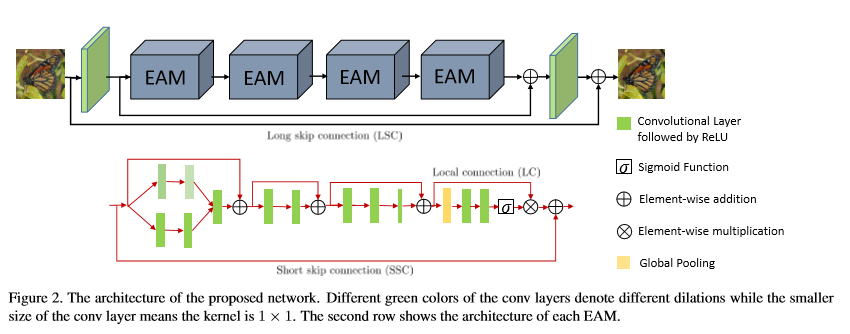

In the research paper, they trained the model using synthetically added noisy images and real noisy image datasets such as SIDD, RENOIR, Poly etc. They also performed data augmentation on these images with rotations of 90, 180, 270 degrees and horizontal flip. <br>
The loss function used for training the model is mean absolute error. <br>

Refer the research paper for detailed explanation : https://arxiv.org/pdf/1904.07396v2.pdf

Modifications done for RIDNet implementation compared to research paper :
1. Will be using only real noisy image datasets. (SIDD and RENOIR)
2. The loss function that will be used is mean squared error instead of mean absolute error.
3. Training for huge number of iterations is not feasible as done in the research paper. Will try to get the best performance within the limitations of system configurations.


In [ ]:
#https://github.com/saeed-anwar/RIDNet
#In the above reference code, short skip connection in EAM network and skip conncetions in the overall network was not included. I will be adding those as well.
class EAM(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)

    self.conv1 = Conv2D(64, (3,3), dilation_rate=1,padding='same',activation='relu')
    self.conv2 = Conv2D(64, (3,3), dilation_rate=2,padding='same',activation='relu')

    self.conv3 = Conv2D(64, (3,3), dilation_rate=3,padding='same',activation='relu')
    self.conv4 = Conv2D(64, (3,3), dilation_rate=4,padding='same',activation='relu')

    self.conv5 = Conv2D(64, (3,3),padding='same',activation='relu')

    self.conv6 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv7 = Conv2D(64, (3,3),padding='same')

    self.conv8 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv9 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv10 = Conv2D(64, (1,1),padding='same')

    self.gap = GlobalAveragePooling2D()

    self.conv11 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv12 = Conv2D(64, (3,3),padding='same',activation='sigmoid')

  def call(self,input):
    conv1 = self.conv1(input)
    conv1 = self.conv2(conv1)

    conv2 = self.conv3(input)
    conv2 = self.conv4(conv2)

    concat = concatenate([conv1,conv2])
    conv3 = self.conv5(concat)
    add1 = Add()([input,conv3])

    conv4 = self.conv6(add1)
    conv4 = self.conv7(conv4)
    add2 = Add()([conv4,add1])
    add2 = Activation('relu')(add2)

    conv5 = self.conv8(add2)
    conv5 = self.conv9(conv5)
    conv5 = self.conv10(conv5)
    add3 = Add()([add2,conv5])
    add3 = Activation('relu')(add3)

    gap = self.gap(add3)
    gap = Reshape((1,1,64))(gap)
    conv6 = self.conv11(gap)
    conv6 = self.conv12(conv6)

    mul = Multiply()([conv6, add3])
    out = Add()([input,mul]) # This is not included in the reference code
    return out

In [ ]:
tf.keras.backend.clear_session()
input = Input(shape=(256, 256, 3))

conv1 = Conv2D(64, (3,3),padding='same')(input)
eam1 = EAM()(conv1)
eam2 = EAM()(eam1)
eam3 = EAM()(eam2)
eam4 = EAM()(eam3)
#add = Add()([eam4,conv1])
conv2 = Conv2D(3, (3,3),padding='same')(eam4)
out = Add()([conv2,input])

RIDNet = Model(input,out)
RIDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())
RIDNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
eam (EAM)                       (None, 256, 256, 64) 447232      conv2d[0][0]                     
__________________________________________________________________________________________________
eam_1 (EAM)                     (None, 256, 256, 64) 447232      eam[0][0]                        
______________________________________________________________________________________________

In [ ]:
batch_size=8
train_dataloader = Dataloder(X_train_patches,y_train_patches, batch_size, shuffle=True)
test_dataloader = Dataloder(X_test_patches,y_test_patches,batch_size, shuffle=True)

In [ ]:
log_dir="logs/model_4"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1,patience=4,min_delta=0.00001)
callback = [tensorboard,reducelr]
RIDNet.fit(train_dataloader,shuffle=True,epochs=20,validation_data= test_dataloader, callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
864/864 [==============================] - 763s 880ms/step - loss: 0.0084 - val_loss: 7.8971e-04
Epoch 2/20
864/864 [==============================] - 759s 878ms/step - loss: 6.8611e-04 - val_loss: 5.6560e-04
Epoch 3/20
864/864 [==============================] - 759s 878ms/step - loss: 5.9954e-04 - val_loss: 5.3389e-04
Epoch 4/20
864/864 [==============================] - 759s 878ms/step - loss: 5.7567e-04 - val_loss: 6.3940e-04
Epoch 5/20
864/864 [==============================] - 759s 878ms/step - loss: 5.3884e-04 - val_loss: 5.0810e-04
Epoch 6/20
864/864 [==============================] - 759s 878ms/step - loss: 5.0159e-04 - val_loss: 4.3873e-04
Epoch 7/20
864/864 [==============================] - 759s 878ms/step - loss: 5.0662e-04 - val_loss: 4.9348e-04
Epoch 8/20
864/864 [==============================] - 759s 878ms/step - loss: 4.3826e-04 - val_loss: 4.9040e-04
Epoch 9/20
864/864 [==============================] - 759s 878ms/step - loss: 4.4637e-04 - val_loss: 5.1630e

In [ ]:
RIDNet.fit(train_dataloader,shuffle=True,epochs=25,initial_epoch=20,validation_data= test_dataloader, callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/25
864/864 [==============================] - 760s 880ms/step - loss: 3.3326e-04 - val_loss: 3.4336e-04
Epoch 22/25
864/864 [==============================] - 759s 879ms/step - loss: 3.2964e-04 - val_loss: 3.3951e-04
Epoch 23/25
864/864 [==============================] - 759s 879ms/step - loss: 3.2743e-04 - val_loss: 3.3431e-04
Epoch 24/25
864/864 [==============================] - 759s 879ms/step - loss: 3.2597e-04 - val_loss: 3.3737e-04
Epoch 25/25
864/864 [==============================] - 759s 879ms/step - loss: 3.2119e-04 - val_loss: 3.3418e-04

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [ ]:
visualize(sample,RIDNet)

In [ ]:
psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy = psnr_and_ssim(X_test,y_test,RIDNet)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)

PSNR before denoising : 18.744082816694764
PSNR after denoising : 36.59470080855075
SSIM before denoising : 0.46697836030999035
SSIM after denoising : 0.8809891053283976


In [ ]:
RIDNet.save('RIDNet.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
RIDNet = tf.keras.models.load_model('/content/RIDNet.h5',custom_objects={'EAM':EAM})

In [ ]:
%tensorboard --logdir "/content/logs/model_4"

In [ ]:
model_size = round((os.stat('/content/RIDNet.h5').st_size)/(1024**2),3)
PSNR.append(round(psnr_de_nsy,3))
SSIM.append(round(ssim_de_nsy,3))
PSNR_imp.append(round(psnr_de_nsy-psnr_nsy,3))
SSIM_imp.append(round(ssim_de_nsy-ssim_nsy,3))
size.append(model_size)

#Overall Model Performance Results

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("Model", ['Original clean-noisy image pairs (No model)','Autoencoder','CBDNet','PRIDNet','RIDNet'])
x.add_column('PSNR',PSNR)
x.add_column('SSIM',SSIM)
x.add_column('PSNR Improvement',PSNR_imp)
x.add_column('SSIM Improvement',SSIM_imp)
x.add_column('Model size in MB',size)
print(x)

+---------------------------------------------+--------+-------+------------------+------------------+------------------+
|                    Model                    |  PSNR  |  SSIM | PSNR Improvement | SSIM Improvement | Model size in MB |
+---------------------------------------------+--------+-------+------------------+------------------+------------------+
| Original clean-noisy image pairs (No model) | 18.744 | 0.467 |        -         |        -         |        -         |
|                 Autoencoder                 | 31.194 | 0.739 |      12.45       |      0.272       |      3.891       |
|                    CBDNet                   | 35.286 | 0.849 |      16.542      |      0.382       |      52.512      |
|                   PRIDNet                   | 35.126 | 0.848 |      16.382      |      0.381       |     900.622      |
|                    RIDNet                   | 36.595 | 0.881 |      17.851      |      0.414       |      20.956      |
+-----------------------